In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import os
import pandas as pd

from scipy import stats
import imageio

# add the top level directory to allow it to be imported
import sys
sys.path.append(os.path.split(os.getcwd())[0])
from utilities import plotting_utilities
from utilities import helper_functions

pd.set_option('display.max_columns', 500)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
window_size=1.5 # number of seconds before/after each stimulus event over which to integrate activity for the purpose of calling a cell 'responsive'
significance_level = 0.05 # level at which to declare a response 'significant'

In [3]:
data_path = os.path.join(os.path.split(os.getcwd())[0],'data')
session_list = pd.read_csv(os.path.join(os.path.join(data_path,'session_list.csv')))
active_sessions = session_list.query('session_type == "active"')
active_sessions

,mouse_id,sex,genotype,AP_coord,ML_coord,DV_coord,session_type,recording_date,processing_date
18,M332849,M,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,1.5,3.125,2.5,active,2018-06-14 12:44:33.658000,2018-07-26 12:11:01.983524799-07:00
19,M348126,F,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai94(TITL-...,1.5,2.625,2.5,active,2018-06-13 13:47:38.463000,2018-07-26 18:15:45.828682184-07:00
20,M351181,F,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai94(TITL-...,1.5,2.625,2.5,active,2018-03-14 14:32:15.328000,2018-07-26 18:59:36.293976068-07:00
21,M397408,F,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,1.5,2.625,2.5,active,2018-11-01 11:40:14.487000,2019-01-22 01:32:10.700291872-08:00


In [4]:
session = {}
for idx,row in active_sessions.reset_index().iterrows():
    session[row['mouse_id']] = helper_functions.load_session(row['mouse_id'], session_type='active')
    print('on session {} of {}   '.format(idx+1,len(active_sessions)),end='\r')

In [5]:
session

{'M332849': <utilities.helper_functions.Session at 0x7f76f07b5438>,
 'M348126': <utilities.helper_functions.Session at 0x7f76f07b5588>,
 'M351181': <utilities.helper_functions.Session at 0x7f76f0778e48>,
 'M397408': <utilities.helper_functions.Session at 0x7f76f07b52e8>}

## build out responsiveness summary

In [6]:
# frames before and after each event to include in event-triggered averages
frame_before=200
frame_after=200

event_types = ['hit','miss','fa','cr']   
mean_response_dfs = {event_type:pd.DataFrame(
    {'t':np.linspace(-frame_before*0.05,(frame_after-1)*0.05,frame_before+frame_after)}
) for event_type in event_types}

responsiveness_summary_all = []
for ii, mouse_id in enumerate(session.keys()):
    print('on {} of {}'.format(ii,len(session.keys())))

    # set responsiveness_data as an attribute of the session:
    session[mouse_id].responsiveness_data = helper_functions.get_responsiveness_data(
        session[mouse_id], 
        window_size=window_size
    )
    
    session[mouse_id].responsiveness_summary = helper_functions.build_responsiveness_summary(
        session[mouse_id],
        window_size = window_size
    )
    responsiveness_summary_all.append(session[mouse_id].responsiveness_summary)

    # build out datatframes containing mean resonses for every cell and every event type
    for cell_id in session[mouse_id].filtered_cell_ids:
        for condition in ['hit','miss','fa','cr']:
            events = session[mouse_id].event_dict['{}_events'.format(condition)]
            dat = helper_functions.get_responses(
                session[mouse_id],
                cell_id,
                events,
                frame_before = frame_before,
                frame_after = frame_after
            )
            mean_response_dfs[condition]['{}_{}'.format(mouse_id,cell_id)] = dat['trace_mean']

responsiveness_summary_all = pd.concat(responsiveness_summary_all)
responsiveness_summary_all['integral_change_magnitude'] = (
    responsiveness_summary_all['post_stim_integral_mean'] - responsiveness_summary_all['pre_stim_integral_mean']
)
responsiveness_summary_all['mean_change_magnitude'] = (
    responsiveness_summary_all['post_stim_mean_all'] - responsiveness_summary_all['pre_stim_mean_all']
)

on 0 of 4


/home/dougo/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 47 results
  r = func(a, **kwargs)
/home/dougo/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 93 results
  r = func(a, **kwargs)
/home/dougo/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 147 results
  r = func(a, **kwargs)
/home/dougo/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 193 results
  r = func(a, **kwargs)


on 1 of 4
on 2 of 4


/home/dougo/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 63 results
  r = func(a, **kwargs)


on 3 of 4


/home/dougo/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 92 results
  r = func(a, **kwargs)
/home/dougo/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 85 results
  r = func(a, **kwargs)
/home/dougo/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 192 results
  r = func(a, **kwargs)
/home/dougo/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 9 results
  r = func(a, **kwargs)


In [7]:
responsiveness_summary_all.to_csv('active_responsiveness_summary.csv', index=False)

In [8]:
responsiveness_summary_all.sample(5)

,cell_id,mouse_id,condition,number_of_trials,pre_stim_integral_mean,post_stim_integral_mean,p-value_on_integrals,direction_of_effect_on_integrals,pre_stim_mean_all,post_stim_mean_all,p-value_on_means,direction_of_effect_on_means,integral_change_magnitude,mean_change_magnitude
152,C039,M351181,hit,48,-0.160626,-0.298770,0.972061,-1.0,-0.005843,-0.012682,0.959821,-1.0,-0.138144,-0.006839
299,C092,M348126,cr,64,-9.559780,-7.546193,0.335863,1.0,-0.318297,-0.258528,0.404711,1.0,2.013587,0.059769
247,C075,M348126,cr,64,8.347925,2.132170,0.082730,-1.0,0.281656,0.073356,0.089060,-1.0,-6.215755,-0.208301
339,C107,M351181,cr,46,-2.243739,-5.969678,0.308583,-1.0,-0.077303,-0.205419,0.309022,-1.0,-3.725939,-0.128116
211,C063,M332849,cr,72,-5.544825,-7.538508,0.303719,-1.0,-0.191202,-0.260772,0.295632,-1.0,-1.993682,-0.069570


## plot responsiveness histograms

In [9]:
def plot_mod_index_hist(index_vals, significant, ax, bin_edges=np.arange(-2,2,0.1)):
    '''
    index_vals (array of float): values of the index you want to plot
    significant (array of bool): whether each index val is significant or not
    '''
    
    ax.hist([index_vals[significant],index_vals[~significant]], 
             color=['k','darkgrey'], edgecolor='None', stacked=True, 
             bins=bin_edges, rwidth=0.8, density=True)


def plot_response_histograms(ax=None, significance_threshold=0.05):
    '''
    ax should be a 1x4 array of axis handles if passed
    '''
    if ax is None:
        fig,ax=plt.subplots(1,4,figsize=(20,5),sharex=True, sharey=False)
        
    titles = ['Hits','False Alarms','Misses','Correct Rejects']
    for ii,condition in enumerate(['hit','fa','miss','cr']):
        magnitude = responsiveness_summary_all.query('condition == @condition')['mean_change_magnitude']
#         magnitude = responsiveness_summary_all.query('condition == @condition')['integral_change_magnitude']
        significant = responsiveness_summary_all.query('condition == @condition')['p-value_on_means'] < significance_threshold
        plot_mod_index_hist(
            magnitude,
            significant,
            ax[ii]
        )

        axins = inset_axes(ax[ii], width="40%", height="40%", loc=1)

        ax[ii].set_title('{}\nfraction modulated cells: {:0.3f}'.format(titles[ii],significant.mean()))

    #     ax[ii].axvline(0,linestyle=':',color='k',)
        axins.pie(
            [significant.sum(),len(significant)-significant.sum()],
            colors=['black','gray'],
            labels=['','']
        )
        ax[ii].set_xlabel('change in mean (z-score)', fontsize=16)
        ax[ii].set_yticks([])
    ax[0].set_ylabel('fraction')
    sns.despine()

In [10]:
condition='hit'
significance_threshold=0.05
significant = responsiveness_summary_all.query('condition == @condition')['p-value_on_means'] < significance_threshold
np.mean(significant)

0.6281690140845071

In [11]:
responsiveness_summary_all

,cell_id,mouse_id,condition,number_of_trials,pre_stim_integral_mean,post_stim_integral_mean,p-value_on_integrals,direction_of_effect_on_integrals,pre_stim_mean_all,post_stim_mean_all,p-value_on_means,direction_of_effect_on_means,integral_change_magnitude,mean_change_magnitude
0,C000,M332849,hit,52,1.319359,-18.435498,2.614153e-62,-1.0,0.046859,-0.642261,2.998179e-62,-1.0,-19.754857,-0.689120
1,C000,M332849,miss,67,1.319359,0.020795,9.413594e-02,-1.0,0.046859,0.003840,1.128578e-01,-1.0,-1.298564,-0.043019
2,C000,M332849,fa,193,1.319359,1.075905,6.597235e-01,-1.0,0.046859,0.038185,6.579041e-01,-1.0,-0.243454,-0.008674
3,C000,M332849,cr,72,1.319359,1.599180,7.130157e-01,1.0,0.046859,0.057014,7.027604e-01,1.0,0.279821,0.010155
4,C001,M332849,hit,52,-0.039754,-1.058261,7.294250e-01,-1.0,-0.000529,-0.036923,7.186270e-01,-1.0,-1.018507,-0.036394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,C158,M397408,cr,66,-1.499286,-2.616868,3.950994e-01,-1.0,-0.051200,-0.091397,3.728829e-01,-1.0,-1.117582,-0.040197
108,C165,M397408,hit,51,3.137193,-4.038393,6.457627e-04,-1.0,0.106194,-0.146150,4.877292e-04,-1.0,-7.175585,-0.252344
109,C165,M397408,miss,40,3.137193,1.763943,5.587569e-01,-1.0,0.106194,0.062907,5.918370e-01,-1.0,-1.373250,-0.043287
110,C165,M397408,fa,300,3.137193,-3.914768,6.280911e-12,-1.0,0.106194,-0.133257,1.133583e-11,-1.0,-7.051961,-0.239452


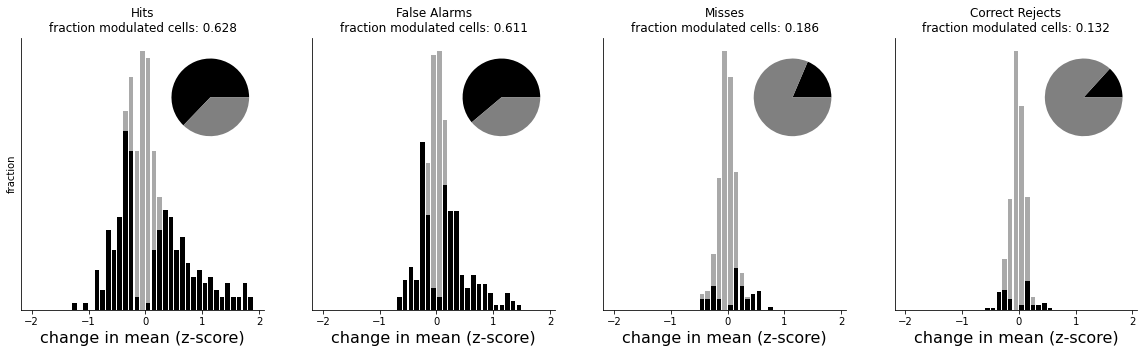

In [12]:
plot_response_histograms(ax=None, significance_threshold=0.05)

## plot response heatmaps

In [13]:
def plot_heatmaps(ax=None, order_by_hits=False):
    if ax is None:
        fig,ax=plt.subplots(1,4,figsize=(12,5))

    tmin = mean_response_dfs['hit']['t'].min()
    tmax = mean_response_dfs['hit']['t'].max()

    titles = ['Hits','False Alarms','Misses','Correct Rejects']
    event_type_order = ['hit','fa','miss','cr']
    for ii,event_type in enumerate(event_type_order):
        idx_for_mean = mean_response_dfs[event_type][['t']].query('t>0 and t<1').index
        if order_by_hits == False:
            responsiveness_summary_all.query('condition == @event_type').sort_values(by='mean_change_magnitude',ascending=False)
            col_order = []
            for idx,row in responsiveness_summary_all.query('condition == "hit"').sort_values(by='mean_change_magnitude',ascending=False).iterrows():
                col_order.append(row['mouse_id']+'_'+row['cell_id'])
        else:
            responsiveness_summary_all.query('condition == @event_type').sort_values(by='mean_change_magnitude',ascending=False)
            col_order = []
            for idx,row in responsiveness_summary_all.query('condition == "hit"').sort_values(by='mean_change_magnitude',ascending=False).iterrows():
                col_order.append(row['mouse_id']+'_'+row['cell_id'])
        arr = mean_response_dfs[event_type][col_order].values

        ax[ii].imshow(
            arr.T,
            clim=[-5,5],
            cmap='seismic',
            aspect='auto',
            extent=(tmin,tmax,0,len(col_order)),
            interpolation='none'
        )

        ax[ii].set_title(titles[ii])
        ax[ii].set_yticks([])
        ax[ii].set_xticks([0,2,4])
        ax[ii].set_xlabel('time from\nevent (s)')
        ax[ii].axvline(0,color='black',alpha=0.5,linewidth=3)

        ax[ii].set_xlim(-1,5)

      

In [14]:
responsiveness_summary_all.query('condition == "hit"').sort_values(by='mean_change_magnitude',ascending=False)
col_order = []
for idx,row in responsiveness_summary_all.query('condition == "hit"').sort_values(by='mean_change_magnitude',ascending=False).iterrows():
    col_order.append(row['mouse_id']+'_'+row['cell_id'])

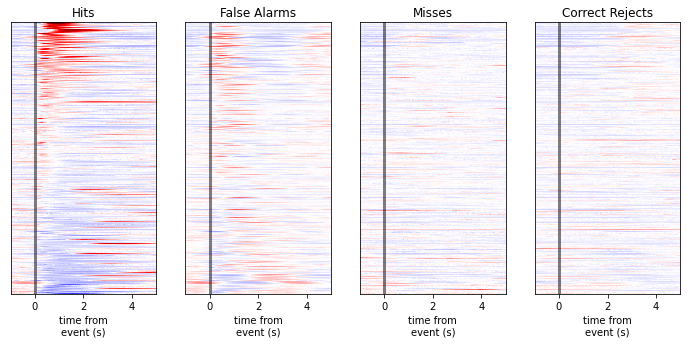

In [15]:
plot_heatmaps(ax=None, order_by_hits=True)

## plot example cells

In [16]:
facilitated = responsiveness_summary_all[
    (responsiveness_summary_all['condition'] == 'hit')
    &(responsiveness_summary_all['p-value_on_means'] < significance_level)
    &(responsiveness_summary_all['direction_of_effect_on_means'] > 0)
    &(responsiveness_summary_all['mean_change_magnitude'] > 0.75)
].reset_index()
facilitated.sample(5,random_state=1)

,index,cell_id,mouse_id,condition,number_of_trials,pre_stim_integral_mean,post_stim_integral_mean,p-value_on_integrals,direction_of_effect_on_integrals,pre_stim_mean_all,post_stim_mean_all,p-value_on_means,direction_of_effect_on_means,integral_change_magnitude,mean_change_magnitude
27,172,C048,M348126,hit,48,-9.952482,47.797517,1.024952e-97,1.0,-0.343450,1.590181,9.601645e-96,1.0,57.749999,1.933632
34,344,C110,M348126,hit,48,-7.991606,27.110599,3.319953e-17,1.0,-0.272026,0.930768,2.390414e-17,1.0,35.102206,1.202794
39,196,C054,M351181,hit,48,-1.310219,26.462475,2.762130e-12,1.0,-0.044667,0.883957,7.060754e-12,1.0,27.772694,0.928624
48,92,C103,M397408,hit,51,-2.693514,31.459251,1.929735e-62,1.0,-0.091752,1.078568,3.041721e-63,1.0,34.152765,1.170320
2,80,C020,M332849,hit,52,-6.997729,44.530853,1.064030e-139,1.0,-0.241436,1.554262,6.866368e-142,1.0,51.528581,1.795698


/home/dougo/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/dougo/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/dougo/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 63 results
  r = func(a, **kwargs)
/home/dougo/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/dougo/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 147 results
  r = func(a, **kwargs)
/home/dougo/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 193 results
  r = fu

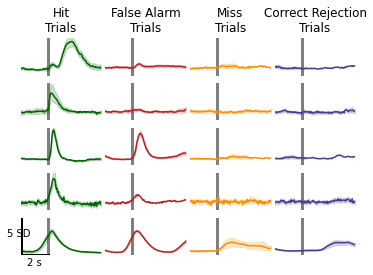

In [17]:
to_plot = facilitated.sample(5,random_state=3)
fig,ax=plt.subplots(len(to_plot),4,figsize=(6,4),sharex=True,sharey=True)

helper_functions.plot_examples(to_plot, session, ax, xlim=(-2,4), ylim=(-1,3))

In [18]:
suppressed = responsiveness_summary_all[
    (responsiveness_summary_all['condition'] == 'hit')
    &(responsiveness_summary_all['p-value_on_means'] < significance_level)
    &(responsiveness_summary_all['direction_of_effect_on_means'] < 0)
    &(responsiveness_summary_all['mean_change_magnitude'] < -0.25)
].reset_index()
suppressed.sample(5,random_state=0)

,index,cell_id,mouse_id,condition,number_of_trials,pre_stim_integral_mean,post_stim_integral_mean,p-value_on_integrals,direction_of_effect_on_integrals,pre_stim_mean_all,post_stim_mean_all,p-value_on_means,direction_of_effect_on_means,integral_change_magnitude,mean_change_magnitude
2,48,C012,M332849,hit,52,0.076458,-10.732862,0.000476,-1.0,0.000949,-0.360863,0.000631,-1.0,-10.809320,-0.361811
13,272,C087,M332849,hit,52,1.039994,-12.905667,0.000002,-1.0,0.033299,-0.443336,0.000002,-1.0,-13.945661,-0.476635
63,348,C111,M348126,hit,48,7.675072,-6.159764,0.000894,-1.0,0.261042,-0.217843,0.000786,-1.0,-13.834836,-0.478885
41,116,C033,M348126,hit,48,3.689646,-14.367576,0.000010,-1.0,0.125539,-0.491890,0.000011,-1.0,-18.057221,-0.617429
48,196,C058,M348126,hit,48,2.716957,-9.442507,0.001286,-1.0,0.093324,-0.326375,0.001188,-1.0,-12.159465,-0.419699


/allen/programs/braintv/workgroups/nc-ophys/Doug/Code/claustrum_imaging_manuscript/utilities/helper_functions.py:142: RuntimeWarning: invalid value encountered in multiply
  all_traces = np.empty((len(events), int(frame_before+frame_after)))*np.NAN
/allen/programs/braintv/workgroups/nc-ophys/Doug/Code/claustrum_imaging_manuscript/utilities/helper_functions.py:142: RuntimeWarning: invalid value encountered in multiply
  all_traces = np.empty((len(events), int(frame_before+frame_after)))*np.NAN
/home/dougo/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 63 results
  r = func(a, **kwargs)
/home/dougo/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/dougo/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 147 results
  r = func(a, **

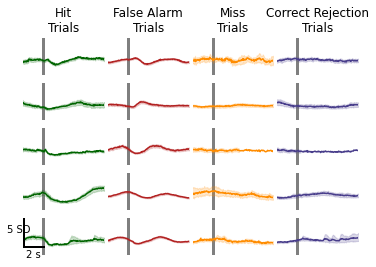

In [19]:
to_plot = suppressed.sample(5,random_state=3)
fig,ax=plt.subplots(len(to_plot),4,figsize=(6,4),sharex=True,sharey=True)

helper_functions.plot_examples(to_plot, session, ax)

## show schematics

In [20]:
def show_schematic(filename, ax=None,):
    if ax is None:
        fig,ax=plt.subplots()
    image = imageio.imread(filename)
    ax.imshow(image,interpolation='nearest')
    ax.axis('off')

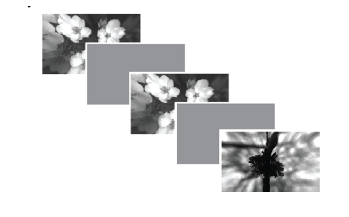

In [21]:
show_schematic('flashing_image_schematic.png')

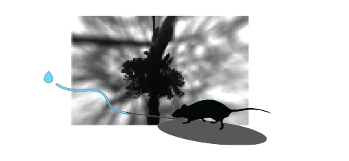

In [22]:
show_schematic('mouse_schematic.png')

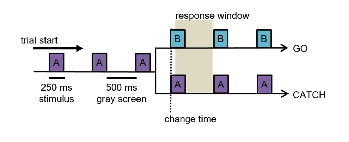

In [23]:
show_schematic('task_schematic.png')

In [24]:
responsiveness_summary_all

,cell_id,mouse_id,condition,number_of_trials,pre_stim_integral_mean,post_stim_integral_mean,p-value_on_integrals,direction_of_effect_on_integrals,pre_stim_mean_all,post_stim_mean_all,p-value_on_means,direction_of_effect_on_means,integral_change_magnitude,mean_change_magnitude
0,C000,M332849,hit,52,1.319359,-18.435498,2.614153e-62,-1.0,0.046859,-0.642261,2.998179e-62,-1.0,-19.754857,-0.689120
1,C000,M332849,miss,67,1.319359,0.020795,9.413594e-02,-1.0,0.046859,0.003840,1.128578e-01,-1.0,-1.298564,-0.043019
2,C000,M332849,fa,193,1.319359,1.075905,6.597235e-01,-1.0,0.046859,0.038185,6.579041e-01,-1.0,-0.243454,-0.008674
3,C000,M332849,cr,72,1.319359,1.599180,7.130157e-01,1.0,0.046859,0.057014,7.027604e-01,1.0,0.279821,0.010155
4,C001,M332849,hit,52,-0.039754,-1.058261,7.294250e-01,-1.0,-0.000529,-0.036923,7.186270e-01,-1.0,-1.018507,-0.036394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,C158,M397408,cr,66,-1.499286,-2.616868,3.950994e-01,-1.0,-0.051200,-0.091397,3.728829e-01,-1.0,-1.117582,-0.040197
108,C165,M397408,hit,51,3.137193,-4.038393,6.457627e-04,-1.0,0.106194,-0.146150,4.877292e-04,-1.0,-7.175585,-0.252344
109,C165,M397408,miss,40,3.137193,1.763943,5.587569e-01,-1.0,0.106194,0.062907,5.918370e-01,-1.0,-1.373250,-0.043287
110,C165,M397408,fa,300,3.137193,-3.914768,6.280911e-12,-1.0,0.106194,-0.133257,1.133583e-11,-1.0,-7.051961,-0.239452


In [25]:
def get_direction_if_responsive(row):
    if row['p-value_on_means'] < significance_level:
        return row['direction_of_effect_on_means']
    else:
        return 0
responsiveness_summary_all['direction_if_signficant'] = responsiveness_summary_all.apply(
    get_direction_if_responsive,
    axis=1
)

In [26]:
significant_cells = responsiveness_summary_all[
    (responsiveness_summary_all['condition'] == 'hit')
    &(responsiveness_summary_all['p-value_on_means'] < significance_level)
]
significant_cells['direction_of_effect_on_means'].value_counts(normalize=True)

 1.0    0.556054
-1.0    0.443946
Name: direction_of_effect_on_means, dtype: float64

In [27]:
responsiveness_summary_all['is_significant'] = responsiveness_summary_all['p-value_on_means'] < significance_level
responsiveness_summary_all[
    (responsiveness_summary_all['condition'] == 'hit')
]['is_significant'].value_counts(normalize=True)

True     0.628169
False    0.371831
Name: is_significant, dtype: float64

In [28]:
responsiveness_summary_all[
    (responsiveness_summary_all['condition'] == 'hit')
]['direction_if_signficant'].value_counts(normalize=True)

 0.0    0.371831
 1.0    0.349296
-1.0    0.278873
Name: direction_if_signficant, dtype: float64

In [29]:
significant_cells['direction_of_effect_on_means'].value_counts(normalize=True)

 1.0    0.556054
-1.0    0.443946
Name: direction_of_effect_on_means, dtype: float64

In [30]:
significant_hit_cells = responsiveness_summary_all[
    (responsiveness_summary_all['condition'] == 'hit')
    &(responsiveness_summary_all['p-value_on_means'] < significance_level)
]
significant_fa_cells = responsiveness_summary_all[
    (responsiveness_summary_all['condition'] == 'fa')
    &(responsiveness_summary_all['p-value_on_means'] < significance_level)
]

In [31]:
significant_hit_cells['mean_change_magnitude'].abs().describe()

count    223.000000
mean       0.643171
std        0.504148
min        0.098183
25%        0.319568
50%        0.478885
75%        0.787052
max        3.091397
Name: mean_change_magnitude, dtype: float64

In [32]:
significant_fa_cells['mean_change_magnitude'].abs().describe()

count    217.000000
mean       0.372906
std        0.274119
min        0.036264
25%        0.192234
50%        0.271270
75%        0.457388
max        1.412736
Name: mean_change_magnitude, dtype: float64

In [33]:
stats.ttest_ind(
    significant_hit_cells['mean_change_magnitude'].abs(),
    significant_fa_cells['mean_change_magnitude'].abs()
)

Ttest_indResult(statistic=6.95905619523582, pvalue=1.2562527506729098e-11)

# Final Figure

/allen/programs/braintv/workgroups/nc-ophys/Doug/Code/claustrum_imaging_manuscript/utilities/helper_functions.py:142: RuntimeWarning: invalid value encountered in multiply
  all_traces = np.empty((len(events), int(frame_before+frame_after)))*np.NAN
/home/dougo/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 147 results
  r = func(a, **kwargs)
/home/dougo/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 193 results
  r = func(a, **kwargs)
/home/dougo/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/dougo/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/dougo/.local/lib/python3.7/site-packages/numpy/lib/function_base.py

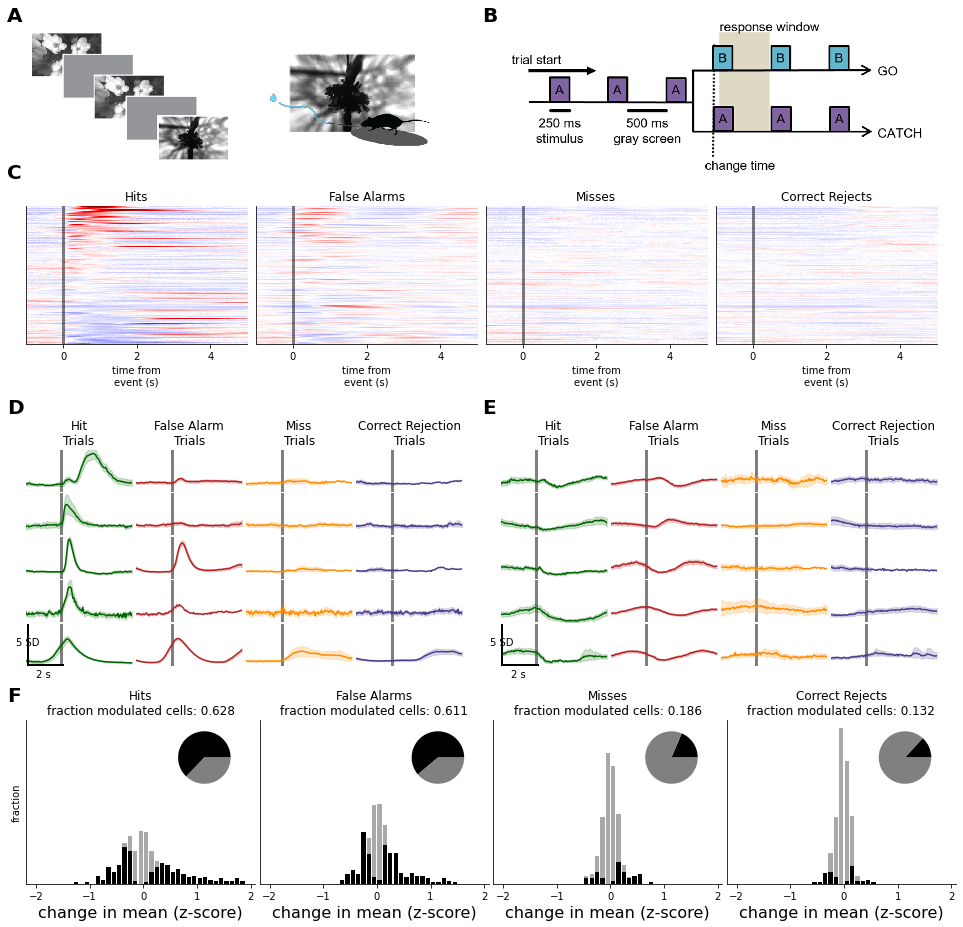

In [34]:
save_fig = True

figsize=(2*8.5,2*8)
figure_3 = plt.figure(figsize=figsize)
n_example_cells = 5
axes = {
    'A1':plotting_utilities.placeAxesOnGrid(figure_3, xspan=[0.0,0.25], yspan=[0,0.2]),
    'A2':plotting_utilities.placeAxesOnGrid(figure_3, xspan=[0.25,0.5], yspan=[0,0.2]),
    'B':plotting_utilities.placeAxesOnGrid(figure_3,  xspan=[0.5,1],    yspan=[0,0.2]),
    'C':plotting_utilities.placeAxesOnGrid(figure_3,  xspan=[0.02,0.98],   yspan=[0.22,0.38], dim=[1,4], sharex=True, sharey=True, wspace=0.04),
    'D':plotting_utilities.placeAxesOnGrid(figure_3,  xspan=[0.02,0.48],   yspan=[0.5,0.75], dim=[n_example_cells,4], sharex=False, sharey=True, wspace=0.04, hspace=0.04),
    'E':plotting_utilities.placeAxesOnGrid(figure_3,  xspan=[0.52,0.98],   yspan=[0.5,0.75], dim=[n_example_cells,4], sharex=False, sharey=True, wspace=0.04, hspace=0.04),
    'F':plotting_utilities.placeAxesOnGrid(figure_3,  xspan=[0.02,1],   yspan=[0.81,1],    dim=[1,4], sharex=True, sharey=True, wspace=0.02),
}
    
show_schematic('flashing_image_schematic.png', ax=axes['A1'])
show_schematic('mouse_schematic.png', ax=axes['A2'])
show_schematic('task_schematic.png', ax=axes['B'])
plot_heatmaps(ax=axes['C'], order_by_hits=True)

helper_functions.plot_examples(facilitated.sample(5,random_state=3), session, ax=axes['D'], xlim=(-2,4), ylim=(-1,3))
helper_functions.plot_examples(suppressed.sample(5,random_state=3), session, ax=axes['E'], xlim=(-2,4), ylim=(-1,3))

plot_response_histograms(ax=axes['F'], significance_threshold=0.05)

# add labels
labels = [
    {'label_text':'A', 'xpos':0,   'ypos':0.0},
    {'label_text':'B', 'xpos':0.5, 'ypos':0.0},
    {'label_text':'C', 'xpos':0,   'ypos':0.18},
    {'label_text':'D', 'xpos':0,   'ypos':0.45},
    {'label_text':'E', 'xpos':0.5, 'ypos':0.45},
    {'label_text':'F', 'xpos':0,   'ypos':0.78},
]
for label in labels:
    plotting_utilities.add_label(
        figure_3,
        label_text = label['label_text'],
        xpos = label['xpos'],
        ypos = label['ypos'],
        fontsize=20,
        weight="bold"
    )

if save_fig:
    plotting_utilities.save_figure(figure_3, fname='figure_3', formats=['.png','.pdf'], size=figsize, dpi=500)

## address overlap in hit/fa population

### first build a pivot table containing the boolean 'is_significant' with the trial condition as the column

In [35]:
responsiveness_summary_all['unique_id'] = responsiveness_summary_all['mouse_id'] + '_' + responsiveness_summary_all['cell_id']
significance_by_condition = responsiveness_summary_all.pivot(index='unique_id', columns='condition',values='is_significant')
significance_by_condition

condition,cr,fa,hit,miss
unique_id,,,,
M332849_C000,False,False,True,False
M332849_C001,False,False,False,True
M332849_C002,False,False,False,False
M332849_C003,False,False,False,False
M332849_C004,False,True,False,False
...,...,...,...,...
M397408_C103,False,True,True,False
M397408_C112,True,True,False,True
M397408_C115,False,True,True,False


### how many total cells?

In [36]:
len(significance_by_condition)

355

### how many hit cells

In [37]:
len(significance_by_condition[significance_by_condition['hit']])

223

### of the hit cells, what fraction are also fa responsive?

In [38]:
significance_by_condition[significance_by_condition['hit']]['fa'].mean()

0.7040358744394619

### how many fa cells?

In [39]:
len(significance_by_condition[significance_by_condition['fa']])

217

### of the fa cells, how many are also hit responsive?

In [40]:
significance_by_condition[significance_by_condition['fa']]['hit'].mean()

0.7235023041474654

### of the cells that are either hit or fa responsive, how many are responsive to both?

In [41]:
significance_by_condition['hit_and_fa'] = significance_by_condition['hit'] & significance_by_condition['fa']
significance_by_condition[significance_by_condition['fa'] | significance_by_condition['hit']]['hit_and_fa'].mean()

0.5547703180212014

## heatmaps of individual cells

In [38]:
def make_heatmaps(session, mouse_id, cell_id, save_or_show='save'):
    fig,ax = plt.subplots(1,4,figsize=(22,4))

    for col,stim_condition in enumerate(['hit','fa','miss','cr']):
        p_val = responsiveness_summary_all.query('mouse_id == @mouse_id and cell_id == @cell_id and condition == @stim_condition')['p-value_on_means'].iloc[0]
        title = 'condition = {}, p-value = {:0.2e}'.format(stim_condition, p_val)
        helper_functions.single_cell_heatmap(
            session = session[mouse_id],
            cell_id = cell_id,
            events = session[mouse_id].event_dict['{}_events'.format(stim_condition)],
            ax=ax[col],
            cbar = True,
            title=title
        )

    fig.tight_layout()
    plt.subplots_adjust(top=0.85)
    fig.suptitle('mouse_id = {}, cell_id = {}'.format(mouse_id, cell_id),fontweight='bold')
    if save_or_show == 'save':
        folder = os.path.join(os.getcwd(), 'single_cell_heatmaps')
        helper_functions.make_folder(folder)
        plotting_utilities.save_figure(fig, os.path.join(folder, 'mouse_{}_cell_{}'.format(mouse_id, cell_id)))
        fig.clf()

In [39]:
col_order = []
for idx,row in responsiveness_summary_all.query('condition == "hit"').sort_values(by='mean_change_magnitude',ascending=False).iterrows():
    col_order.append({'mouse_id':row['mouse_id'], 'cell_id':row['cell_id']})
for entry in col_order:
    make_heatmaps(session, entry['mouse_id'], entry['cell_id'], save_or_show='save')

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>

<Figure size 1584x288 with 0 Axes>